 ## Practical example: hospital districts
 
 In this tutorial, we will create boundaries of Finnish hospital districts
 (*sairaanhoitopiiri* in Finnish) by dissolving municipality boundaries into
 larger entities. Main processing steps include a table join and dissolving the
 municipality geometries into larger entities.
 
 We will combine information from [municipality
 polygons](https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html)
 from Statistics Finland and a [list of health care
 districts](https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat)
 by the Finnish Municipality authority Kuntaliitto.
 
 
 Importing required python packages:

In [1]:
# Import all required packages
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj as prj
import matplotlib.pyplot as plt

## Read in data
 
 - **Municipality polygons** from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html
     - wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs?
     - feature: `tilastointialueet:kunta1000k` (most recent information about municipality polygons)

In [3]:
# For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = (
     "http://geo.stat.fi/geoserver/tilastointialueet/wfs"
     "?request=GetFeature"
     "&typename=tilastointialueet:kunta1000k"
     "&outputformat=JSON"
 )
geodata = gpd.read_file(url)

In [4]:
geodata.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2023,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,2023,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,2023,Alavus,Alavo,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,2023,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,2023,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


In [5]:
# Check length (there are 309 municipalities in Finland in 2022)
len(geodata)

309

In [6]:
# Select and rename columns
geodata.rename(columns={'kunta':'code'}, inplace=True)
geodata = geodata[['code','name', 'geometry']]
geodata.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


<Axes: >

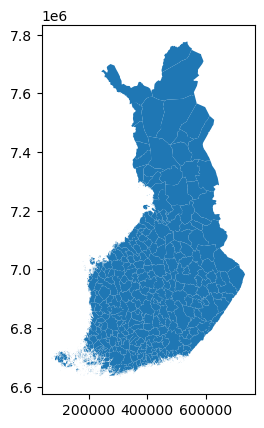

In [7]:
geodata.plot()

In [8]:
geodata.dtypes

code          object
name          object
geometry    geometry
dtype: object

 - **Finnish municipalities with hospital district information** as an Excel spreadsheet 
     - Downloaded from: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat in March 2020. 
     - File `Shp_jäsenkunnat_2020.xls`, sheet `kunnat_shp_2020_ aakkosjärj.` This is the original unaltered file.
     - In this file, "shp" stands for "sairaanhoitopiiri" (hospital district in Finnish)
     
 *Note: this data set does not include Åland (Ahvenanmaa). Åland municipalities are added in the later step.*
 *Note: "hospital districts" is a more proper translation to sairaanhoitopiirit, but in this lesson I use "health care districts" to refer to these entities*
 
 Excel files often come with additional formatting such as metadata on the first lines of the data array. This is why it is a good idea to download the file on your own computer and have a look at the data structure before reading in the file using Python.
 It is also often a good idea to save the file as a csv file before reading in the data. However, it is also possible to read in data directly from Excel. For this, you need to have the xlrd module installed:
 
 ```
 conda install -c conda-forge xlrd
 ```

 Now we are ready to read in the data using pandas.
 
 In the case of this health districts excel the header is located on the 4th row (index 3) of the excel spreadsheet.

In [9]:
# Read in the excel spreadsheet
data = pd.read_excel(
    r"data/Shp_jäsenkunnat_2020.xls", 
    sheet_name="kunnat_shp_2020_ aakkosjärj.", 
    header=3
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Shp_jäsenkunnat_2020.xls'

In [ ]:
data.head()

 In addition, the first row after the header is empty. We can get rid of it using the dropna() -function:

In [ ]:
data.dropna(inplace=True)

Check number of rows (16 Åland municipalities are missing)

In [ ]:
len(data)

The data needs some fixing and cleaning after reading the excel sheet

In [ ]:
# Rename columns from Finnish to English 
data.rename(
    columns={
        "kunta-\nkoodi":"code", 
        'sairaanhoitopiiri':'healthCareDistrict'
        }, 
    inplace=True
)

# Select only useful columns
data = data[['code','healthCareDistrict']]

In [ ]:
data

 Looks better! Now we need to prepare the data for table join. We will use the municipality code as the common key.

In [ ]:
data.dtypes

 The code column is currently a floating point number. We need to modify these codes so that they match the ones in the spatial data:

In [ ]:
# Example using one code
number = data.at[1, "code"]
number

In [ ]:
# Convert this number to character string 020
print("20".zfill(3))

 Let's apply this process on all rows at once, and take into account different number of digits:

In [ ]:
# Convert to character string
data["code"] = data["code"].astype(int).astype('str')

# Add missing zeros to municipality codes
data["code"] = data["code"].str.zfill(3)

In [ ]:
data.head()

## Join Health district info to the municipality polygons

```{code-cell}
# Merge health district info to geodata using "code" as the common key
geodata = geodata.merge(data, on="code", how="left")
```

```{code-cell}
geodata
```

Looks good! However, Municipalities in the Åland island did not have a matching health care district in the data. Let's have a closer look:

```{code-cell}
# List all municipalities that lack health district info:
geodata[geodata["healthCareDistrict"].isnull()].name
```

```{code-cell}
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"
```

Check the count of municipalities per health care disctrict

```{code-cell}
geodata["healthCareDistrict"].value_counts()
```

## Create polygons for health care districts

```{code-cell}
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict')
```

```{code-cell}
districts.reset_index(inplace=True)
```

```{code-cell}
# Select useful columns
districts = districts[["healthCareDistrict", "geometry"]]
```

```{code-cell}
districts
```

```{code-cell}
districts.plot(column='healthCareDistrict', cmap='tab20', k=20)
plt.axis('off')
```

```{code-cell}
# Write GeoJSON in original projection
districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')
```

```{code-cell}
# Re-project to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')
```

That's it! You can elaborate this workflow by joining additional data. For example, if you join population info per municipality you can sum it up for each health care district using the `aggfunc=sum` argument to get population count per health care district.